In [2]:
##### ##### ##### ##### ##### ##### #####
# Note that this is the "lite" version, meaning that there is no spectrogram alongside the trace plot.
# The full version with the spectrogram is shake_udp_live.ipynb
##### ##### ##### ##### ##### ##### #####

### Created by Ian Nesbitt, University of Maine, using RaspberryShake UDP documentation:
### https://manual.raspberryshake.org/udp.html

### Live updating plot created using the following as a template:
### https://github.com/anujgupta82/Musings/blob/master/Dynamic%20or%20Live%20update%20of%20a%20Plot.ipynb

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# NOTE: I don't know why, but you have to run the import cells twice in order for this to work.
# If someone can figure out why, or find a less dirty workaround, please let me know.
# ian dot nesbitt at gmail dot com

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Waiting for data on Port: 18003


<IPython.core.display.Javascript object>


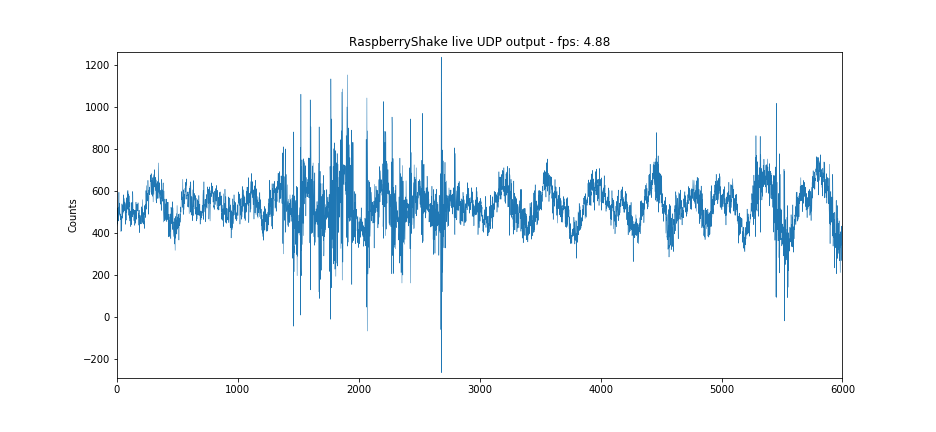

In [ ]:
import socket as s
import math as M
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

ch = 'EHZ'                               # pick your favorite channel
freq = 100                               # sampling frequency in Hz of rshake (1D = 50; 3D & 4D = 100)
seconds = 60                             # number of seconds of data to display
gain = 10                                # higher gain = more spectrogram contrast (value must be positive float)
host = ''                                # blank for localhost (data is being sent here by remote Shake!)
port = 18003                             # Port to bind to

save = False
displ_samps = seconds * freq
wlen = freq / 100
per_lap = 0.9
mult = 8.0
sock = s.socket(s.AF_INET, s.SOCK_DGRAM | s.SO_REUSEADDR)
sock.bind((host, port))

print('Waiting for data on Port:', port)

# from https://docs.obspy.org/_modules/obspy/imaging/spectrogram.html#_nearest_pow_2:
def _nearest_pow_2(x):
    """
    Find power of two nearest to x

    >>> _nearest_pow_2(3)
    2.0
    >>> _nearest_pow_2(15)
    16.0

    :type x: float
    :param x: Number
    :rtype: Int
    :return: Nearest power of 2 to x
    """
    a = M.pow(2, M.ceil(np.log2(x)))
    b = M.pow(2, M.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b

nfft1 = int(_nearest_pow_2(wlen * freq))
nlap1 = int(nfft1 * per_lap)
if mult is not None:
    mult = int(_nearest_pow_2(mult))
    mult = mult * nfft1

#initialize the graph and settings
fig, ax = plt.subplots(figsize=(13,6))
plt.ion()

fig.show()
fig.canvas.draw()

n = 0
stream = []                             # our stream (simple list object)
curr = datetime.now()

while 1:                                # loop forever
    data, addr = sock.recvfrom(1024)    # wait to receive data
    s = data.decode('UTF-8').strip("'{}").split(', ') # clean and listify the data
    if ch in s[0]:                      # only listen to the specific channel
        prev = curr                     # timing
        curr = datetime.now()           # timing
        fps = 1/(curr-prev).total_seconds() # timing
        for smp in s[2:]:               # convert strings to ints
            stream.append(int(smp))
        npts = len(stream)
        if npts > displ_samps:          # if the number of samples exceeds the display value, slice the array
            stream = stream[npts - displ_samps:] # move the array to the right, get rid of old samples
            npts = len(stream)
        ax.clear()                     # ready the plot axis for a new draw
        ax.set_xlim(0, npts)           # being explicit here helps speed things up slightly
        ax.set_ylim(min(stream)-25, max(stream)+25)

        ax.set(title='RaspberryShake live UDP output - fps: %.2f' % (fps), ylabel='Counts')
        ax.plot(stream, linewidth=0.5)
        if save:
            plt.savefig('figs/%05d.png' % n)
            if n == 239:
                print('6k samples reached; frame full')
            n += 1
        else:
            fig.canvas.draw()
